In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

sys.path.append(project_root)

In [2]:
import torch

from src.models.cgcnn import CGCNN
from src.xai.wrappers import CGCNNWrapper
from src.data.loader import get_loaders
from src.utils.io import load_model
from src.xai.gnn_explainer import explain_graph_prediction
from src.utils.config import load_config

In [3]:
yaml_pth = "../configs/test.yaml"
cfg = load_config(yaml_pth)

In [4]:
train_loader, val_loader, test_loader = get_loaders("../data/processed",
                                                    target=["formation_energy_per_atom"],
                                                    batch_size=16,
                                                    num_workers=0,
                                                    train_ratio=0.8,
                                                    val_ratio=0.1,
                                                    seed=42)

model = CGCNN(
        node_input_dim=cfg.model.node_input_dim,
        edge_input_dim=cfg.model.edge_input_dim,
        hidden_dim=cfg.model.hidden_dim,
        num_layers=cfg.model.num_layers,
        output_dim=cfg.model.output_dim,
    )

model = load_model(model, "../checkpoints/cgcnn_test_best.pth", device="cuda")

Model loaded from: ../checkpoints/cgcnn_test_best.pth


In [5]:
data_iter = iter(test_loader)
first_batch = next(data_iter)
data = first_batch[0]
print(data)

Data(x=[18, 118], edge_index=[2, 60], edge_attr=[60, 1], y=[1, 1], material_id='mp-18232')


✅ Explanation saved to: ../explainer_sample0.png


Explanation(edge_mask=[60], prediction=[1, 1], target=[1, 1], x=[18, 118], edge_index=[2, 60])

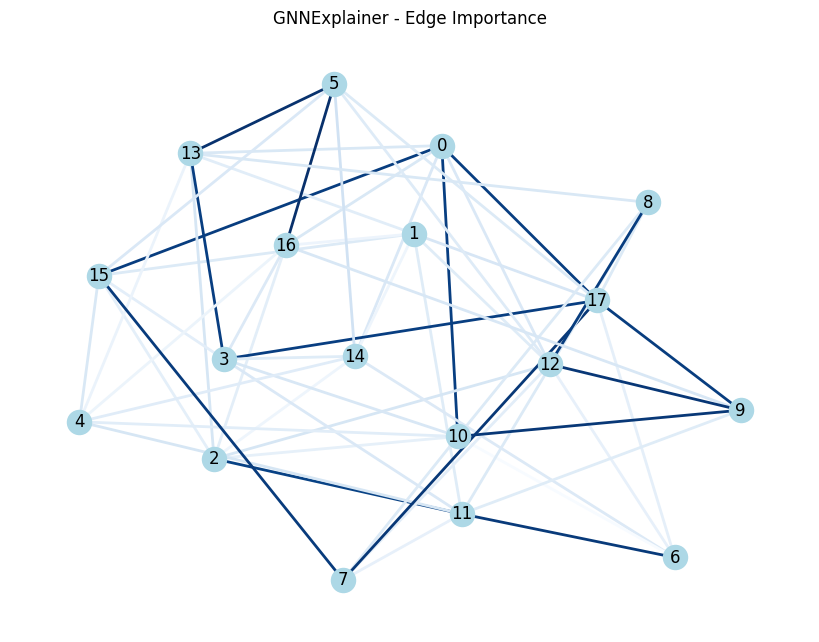

In [6]:
from src.xai.wrappers import CGCNNWrapper
explain_graph_prediction(
    model=CGCNNWrapper(model),
    data=data,
    epochs=100,
    save_path="../explainer_sample0.png",
    device="cuda"
)